# Data Analysis

In [1]:
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import os

# I get this because of a copy warning using dataframes. More info is found here:
# https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
# Ignoring all warnings is a horrible practice if you are running the code for the first time.
# However, upon further research I deemed the warning irrelevant, so I suppress it to make the output clean.
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

# Data Cleaning

In [2]:
def clean_data(df):
    
    #Time when Riot started adding timestamps
    beginning = 1623987436
    
    #Naming the columns
    df.columns = ["puuid", "match_id", "start_time", "duration"]

    #Drop duplicate values
    df.drop_duplicates(inplace=True)

    #Changing from milliseconds to seconds
    df["start_time_seconds"] = df["start_time"]/1000

    #Creating column of datetimes for the start time of games
    df["start_time_date"] = df["start_time_seconds"].apply(lambda x : datetime.datetime.fromtimestamp(int(x)))

    #Start time is measured in epoch time ms, so we convert to seconds
    df["start_time_seconds"] = df["start_time"]/1000
    
    #There are some games where the timestamps are messed up and start at 0, corresponding to 1970 (look up unix time)
    #So we remove these
    df = df[df["start_time_seconds"] > beginning]
    
    #duration is sometimes measured in seconds and sometimes in ms, so we conver to seconds via some condition
    df["duration_seconds"] = df["duration"].apply(lambda x : x/1000  if x/60 > 120 else x)

    #createa column for end_time since this is not tracked in all of the json files
    df["end_time_seconds"] = df["start_time_seconds"] + df["duration_seconds"]

    #Sort the values by start_time
    df.sort_values(by = "start_time_seconds", ascending=True, inplace=True, ignore_index=True)

    #Creating a new column which measures the time difference between the end of a game and the beginning of the next one
    del_t = []
    del_t.append(0)

    for i in range(1,len(df["start_time_seconds"])):

        del_t.append(df["start_time_seconds"][i] - df["end_time_seconds"][i-1])

    #In seconds
    df["del_t"] = del_t

    #Want the time between games in hours
    df["del_t_hours"] = df["del_t"]/(60*60)
    
    return(df)

# Frequency of Games Played for 10 LoL Players

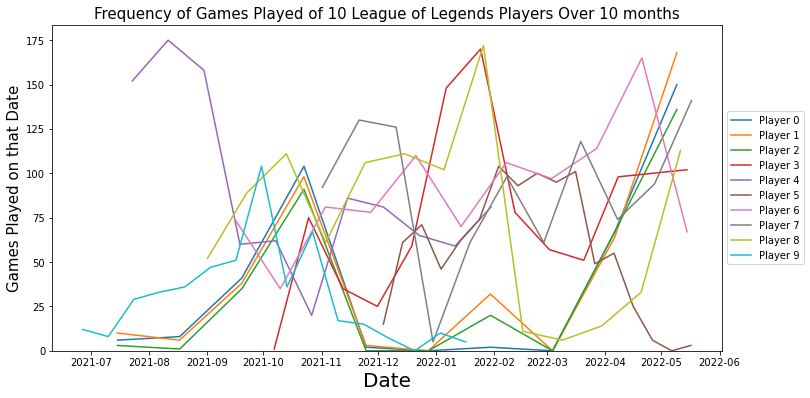

In [3]:
fig, ax = plt.subplots(figsize = (12,6))

c_list = ["tab:blue","tab:orange","tab:green","tab:red","tab:purple","tab:brown","tab:pink","tab:gray","tab:olive","tab:cyan"]

for i, filepath in enumerate(os.listdir("Player_Time_Data_2/")):
    
    df = pd.read_csv("Player_Time_Data_2/{}".format(filepath),
                      dtype='str,str,float,float', 
                      delimiter = " ",
                      usecols=(0,1,2,3),
                      header = None
                    )
    
    df = clean_data(df)
    
    sns.histplot(data = df["start_time_date"], 
                 element = 'poly', 
                 fill= False, 
                 ax = ax, 
                 ls = "solid", 
                 color = c_list[i],
                 label = "Player {}".format(i)
                )
    
plt.xlabel("Date", fontsize = 20)
plt.ylabel("Games Played on that Date", fontsize = 15)
plt.title("Frequency of Games Played of 10 League of Legends Players Over 10 months", fontsize = 15)

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    
    

# Time Between Games Played for 10 LoL Players

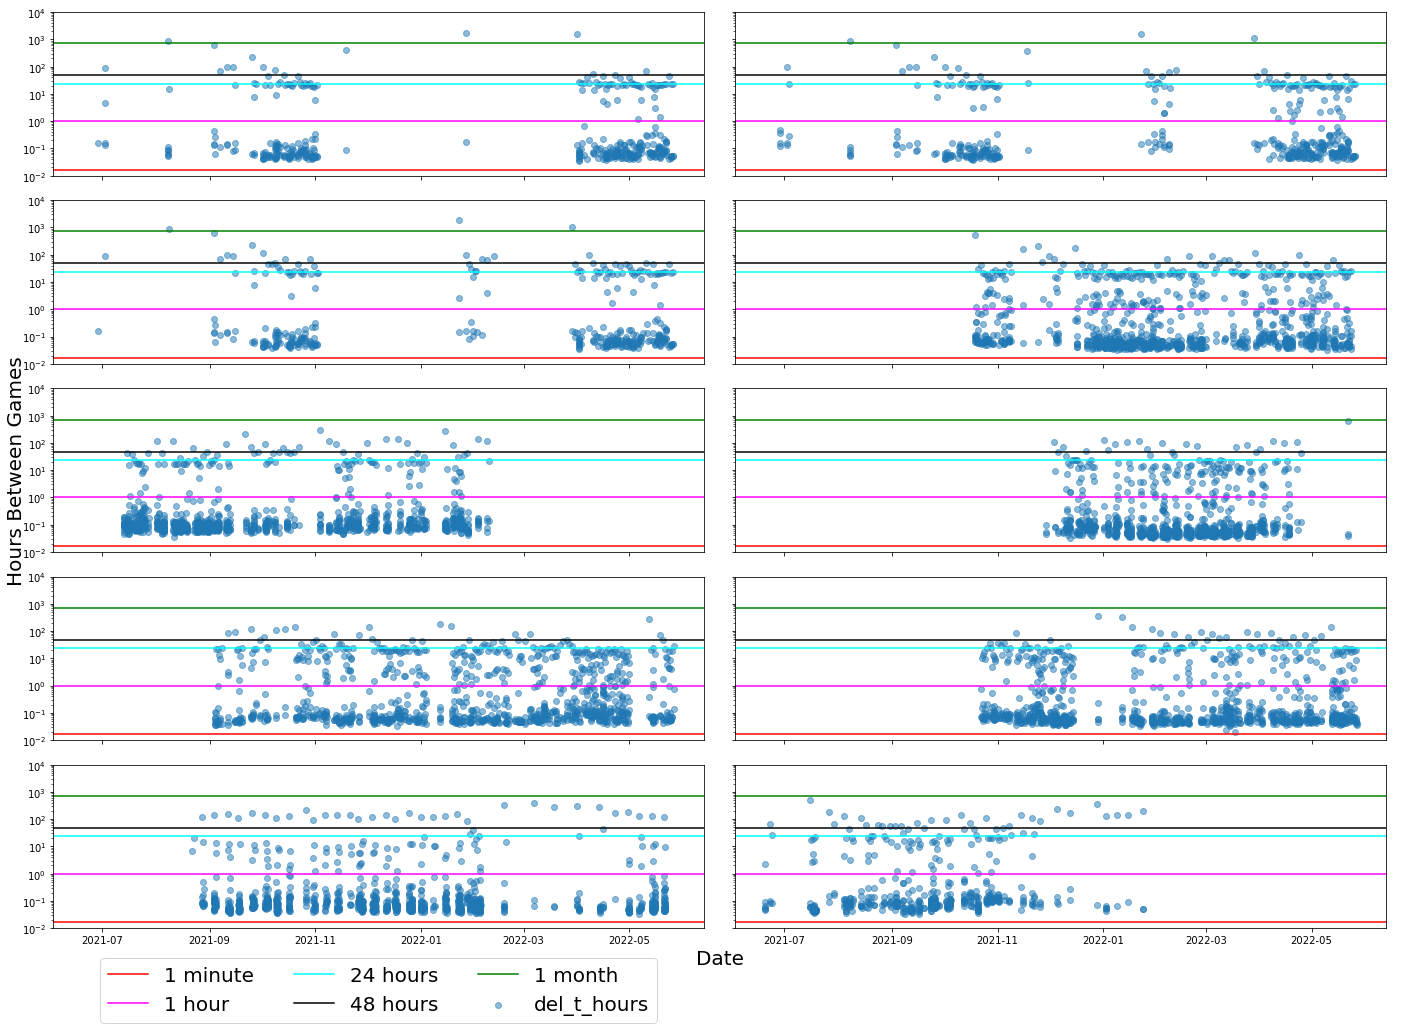

In [14]:
fig, axes = plt.subplots(nrows = 5, 
                       ncols=2, 
                       figsize = (20,15), 
                       sharex=True, 
                       sharey=True)

#axis_list = [(0,0),(0,1),(0,2),(0,3),(0,4),(1,0),(1,1),(1,2),(1,3),(1,4)]
axis_list = [(0,0),(0,1),(1,0),(1,1),(2,0),(2,1),(3,0),(3,1),(4,0),(4,1)]

for i, filepath in enumerate(os.listdir("Player_Time_Data_2/")):
    
    df = pd.read_csv("Player_Time_Data_2/{}".format(filepath),
                      dtype='str,str,float,float', 
                      delimiter = " ",
                      usecols=(0,1,2,3),
                      header = None
                    )
    
    df = clean_data(df)
    
    axes[axis_list[i]].scatter(x = "start_time_date", y = "del_t_hours", data = df, alpha = .5)
    
    
    axes[axis_list[i]].axhline(y = 1/60,c = "red", label = "1 minute")
    axes[axis_list[i]].axhline(y = 1,   c = "magenta", label = "1 hour")
    axes[axis_list[i]].axhline(y = 24,  c = "cyan", label = "24 hours")
    axes[axis_list[i]].axhline(y = 48,  c = "black", label = "48 hours")
    axes[axis_list[i]].axhline(y = 24*30,  c = "green", label = "1 month")
    
    axes[axis_list[i]].set_yscale("log")
    
    #plt.xlabel("Date", fontsize = 20)
    #plt.ylabel("Hours Between Games", fontsize = 20)
    #plt.grid()
    plt.ylim(.01,10000)

    
fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axis
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.xlabel("Date", fontsize = 20)
plt.ylabel("Hours Between Games", fontsize = 20)
  
fig.subplots_adjust(top=0.9, left=0.1, right=0.9, bottom=0.12)  # create some space below the plots by increasing the bottom-value
axes.flatten()[-2].legend(loc='upper center', bbox_to_anchor=(0.5, -0.12), ncol=3, prop={'size': 20})    

'''
import matplotlib.patches as mpatches

labels = ['1 minute', '1 hour', '24 hours', '48 hours']


# now, create an artist for each color
red_patch = mpatches.Patch(facecolor='r', edgecolor='#000000') #this will create a red bar with black borders, you can leave out edgecolor if you do not want the borders
magenta_patch = mpatches.Patch(facecolor='m', edgecolor='#000000')
cyan_patch = mpatches.Patch(facecolor='c', edgecolor='#000000')
black_patch = mpatches.Patch(facecolor='k', edgecolor='#000000')




fig.legend(handles = [red_patch, magenta_patch, cyan_patch, black_patch],labels=labels,
       loc="center right", 
       borderaxespad=0.1, 
       prop={'size': 20},
       bbox_to_anchor=(1, 0.5)
          )
plt.subplots_adjust(right=0.85) #adjust the subplot to the right for the legend
'''
plt.tight_layout()

# Time Between Games Played for one LoL Player

In [5]:
df = pd.read_csv("Player_Time_Data_2/player_0_times.txt",
                      dtype='str,str,float,float', 
                      delimiter = " ",
                      usecols=(0,1,2,3),
                      header = None
                    )
    
df = clean_data(df)

(0.01, 10000)

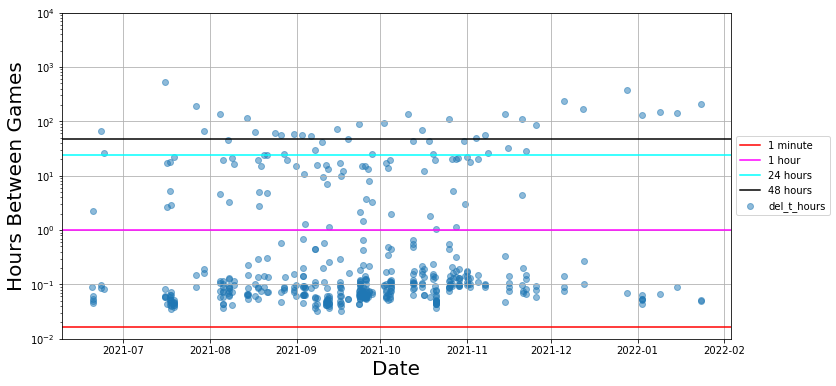

In [10]:
fig, ax = plt.subplots(figsize = (12,6))

ax.scatter(x = "start_time_date", y = "del_t_hours", data = df, alpha = .5)

ax.axhline(y = 1/60,c = "red", label = "1 minute")
ax.axhline(y = 1,   c = "magenta", label = "1 hour")
ax.axhline(y = 24,  c = "cyan", label = "24 hours")
ax.axhline(y = 48,  c = "black", label = "48 hours")

ax.set_yscale("log")
plt.xlabel("Date", fontsize = 20)
plt.ylabel("Hours Between Games", fontsize = 20)


plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid()
plt.ylim(.01,10000)